# NYC Parking Tickets: An Exploratory Analysis

### Objectives of the Case Study
Primarily, this case study is meant as a deep dive into the usage of Spark. As you saw while working with Spark, its syntax behaves differently from a regular Python syntax. One of the major objectives of this case study is to gain familiarity with how analysis works in PySpark as opposed to base Python.

Learning the basic idea behind using functions in PySpark can help in using other libraries like SparkR. If you are in a company where R is a primary language, you can easily pick up SparkR syntax and use Spark’s processing power.

The process of running a model-building command boils down to a few lines of code. While drawing inferences from data, the most time-consuming step is preparing the data up to the point of model building. So, this case study will focus more on exploratory analysis.

In an attempt to scientifically analyse this phenomenon, the NYC Police Department has collected data for parking tickets. Of these, the data files for multiple years are publicly available on Kaggle. We will try and perform some exploratory analysis on a part of this data. Spark will allow us to analyse the full files at high speeds as opposed to taking a series of random samples that will approximate the population. For the scope of this analysis, we will analyse the parking tickets over the year 2017. 

---

### Loading Necessary Libraries and Initializing

In [1]:
# Importing PySpark related Libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, udf, date_format
from pyspark.sql.types import StringType, TimestampType

# Importing Visualization related Libraries
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# We will work with Spark 2 and thus use Spark Session Object (and not Spark Context Object)

spark = SparkSession.builder.appName("Parking Ticket Data Analysis").getOrCreate()

---

### Loading Necessary Data

In [3]:
# Loading the data from CSV to Spark Session.
# Viewing the Schema of the loaded data.

df = spark.read.csv('/common_folder/nyc_parking/Parking_Violations_Issued_-_Fiscal_Year_2017.csv', header=True)
df.printSchema()

root
 |-- Summons Number: string (nullable = true)
 |-- Plate ID: string (nullable = true)
 |-- Registration State: string (nullable = true)
 |-- Issue Date: string (nullable = true)
 |-- Violation Code: string (nullable = true)
 |-- Vehicle Body Type: string (nullable = true)
 |-- Vehicle Make: string (nullable = true)
 |-- Violation Precinct: string (nullable = true)
 |-- Issuer Precinct: string (nullable = true)
 |-- Violation Time: string (nullable = true)



In [4]:
# Viewing top 5 rows of the loaded data.

df.show(5)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|Summons Number|Plate ID|Registration State|Issue Date|Violation Code|Vehicle Body Type|Vehicle Make|Violation Precinct|Issuer Precinct|Violation Time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|    5092469481| GZH7067|                NY|2016-07-10|             7|             SUBN|       TOYOT|                 0|              0|         0143A|
|    5092451658| GZH7067|                NY|2016-07-08|             7|             SUBN|       TOYOT|                 0|              0|         0400P|
|    4006265037| FZX9232|                NY|2016-08-23|             5|             SUBN|        FORD|                 0|              0|         0233P|
|    8478629828| 66623ME|                NY|2017-06-14|            47|             REFG|

In [5]:
# Casting to required datatypes as per the dictionary
# Dictionary URL: https://www.kaggle.com/new-york-city/nyc-parking-tickets/data

df = df.withColumn("Summons_Number_2", col("Summons Number").cast("Long"))
df = df.withColumn("Issue_Date_2", col("Issue Date").cast("Date"))
df = df.withColumn("Violation_Code_2", col("Violation Code").cast("Int"))
df = df.withColumn("Violation_Precinct_2", col("Violation Precinct").cast("Int"))
df = df.withColumn("Issuer_Precinct_2", col("Issuer Precinct").cast("Int"))

In [6]:
# We can select Data for year 2017 alone using WHERE clause in below query.
# But as per the Live session, considering all data to be from 2017
# Selecting columns with modified datatypes only for further analysis

df.createOrReplaceTempView("df_complete_table")
df = spark.sql(
    "SELECT \
    `Summons_Number_2` as `summons_number`, \
    `Plate ID` as `plate_id`, \
    `Registration State` as `registration_state`, \
    `Issue_Date_2` as `issue_date`, \
    `Violation_Code_2` as `violation_code`, \
    `Vehicle Body Type` as `vehicle_body_type`, \
    `Vehicle Make` as `vehicle_make`, \
    `Violation_Precinct_2` as `violation_precinct`, \
    `Issuer_Precinct_2` as `issuer_precinct`, \
    `Violation Time` as `violation_time` \
    FROM df_complete_table"
)
df.show(5)

+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|summons_number|plate_id|registration_state|issue_date|violation_code|vehicle_body_type|vehicle_make|violation_precinct|issuer_precinct|violation_time|
+--------------+--------+------------------+----------+--------------+-----------------+------------+------------------+---------------+--------------+
|    5092469481| GZH7067|                NY|2016-07-10|             7|             SUBN|       TOYOT|                 0|              0|         0143A|
|    5092451658| GZH7067|                NY|2016-07-08|             7|             SUBN|       TOYOT|                 0|              0|         0400P|
|    4006265037| FZX9232|                NY|2016-08-23|             5|             SUBN|        FORD|                 0|              0|         0233P|
|    8478629828| 66623ME|                NY|2017-06-14|            47|             REFG|

---

### Looking into the Data

In [7]:
# Viewing the modified Schema of the data.

df.printSchema()

root
 |-- summons_number: long (nullable = true)
 |-- plate_id: string (nullable = true)
 |-- registration_state: string (nullable = true)
 |-- issue_date: date (nullable = true)
 |-- violation_code: integer (nullable = true)
 |-- vehicle_body_type: string (nullable = true)
 |-- vehicle_make: string (nullable = true)
 |-- violation_precinct: integer (nullable = true)
 |-- issuer_precinct: integer (nullable = true)
 |-- violation_time: string (nullable = true)



In [8]:
# Description of Summons Number Column
df.describe("summons_number").show()

+-------+--------------------+
|summary|      summons_number|
+-------+--------------------+
|  count|            10803028|
|   mean| 6.817447029065788E9|
| stddev|2.3202339623282275E9|
|    min|          1002884949|
|    max|          8585600044|
+-------+--------------------+



In [9]:
# Description of Plate ID Column
df.describe("plate_id").show()

+-------+--------+
|summary|plate_id|
+-------+--------+
|  count|10803028|
|   mean|Infinity|
| stddev|     NaN|
|    min|   #1MOM|
|    max|       ~|
+-------+--------+



In [10]:
# Description of Registration State Column
df.describe("registration_state").show()

+-------+------------------+
|summary|registration_state|
+-------+------------------+
|  count|          10803028|
|   mean|              99.0|
| stddev|               0.0|
|    min|                99|
|    max|                WY|
+-------+------------------+



In [11]:
# Description of Issue Date Column
df.describe("issue_date").show()

+-------+
|summary|
+-------+
|  count|
|   mean|
| stddev|
|    min|
|    max|
+-------+



In [12]:
# Description of Violation Code Column
df.describe("violation_code").show()

+-------+------------------+
|summary|    violation_code|
+-------+------------------+
|  count|          10803028|
|   mean|34.599430455979565|
| stddev|19.359868716323483|
|    min|                 0|
|    max|                99|
+-------+------------------+



In [13]:
# Description of Vehicle Body Type Column
df.describe("vehicle_body_type").show()

+-------+------------------+
|summary| vehicle_body_type|
+-------+------------------+
|  count|          10803028|
|   mean|3.9258887134586864|
| stddev|0.5013415469252522|
|    min|                00|
|    max|               nan|
+-------+------------------+



In [14]:
# Description of Vehicle Make Column
df.describe("vehicle_make").show()

+-------+-----------------+
|summary|     vehicle_make|
+-------+-----------------+
|  count|         10803028|
|   mean|6519.974025974026|
| stddev|18091.25738914709|
|    min|            ,FREI|
|    max|              nan|
+-------+-----------------+



In [15]:
# Description of Violation Precinct Column
df.describe("violation_precinct").show()

+-------+------------------+
|summary|violation_precinct|
+-------+------------------+
|  count|          10803028|
|   mean| 45.01216260848347|
| stddev|40.552560268435805|
|    min|                 0|
|    max|               933|
+-------+------------------+



In [16]:
# Description of Issuer Precinct Column
df.describe("issuer_precinct").show()

+-------+-----------------+
|summary|  issuer_precinct|
+-------+-----------------+
|  count|         10803028|
|   mean|46.82931211508477|
| stddev|62.66703577269467|
|    min|                0|
|    max|              997|
+-------+-----------------+



In [17]:
# Description of Violation Time Column
df.describe("violation_time").show()

+-------+-----------------+
|summary|   violation_time|
+-------+-----------------+
|  count|         10803028|
|   mean|909.2857142857143|
| stddev|791.8453853409226|
|    min|            .240P|
|    max|              nan|
+-------+-----------------+



---

### Performing Basic Exploratory Data Analysis

In [18]:
# Creating temporary SQL view to proceed with further Analysis.

df.createOrReplaceTempView("df_table")

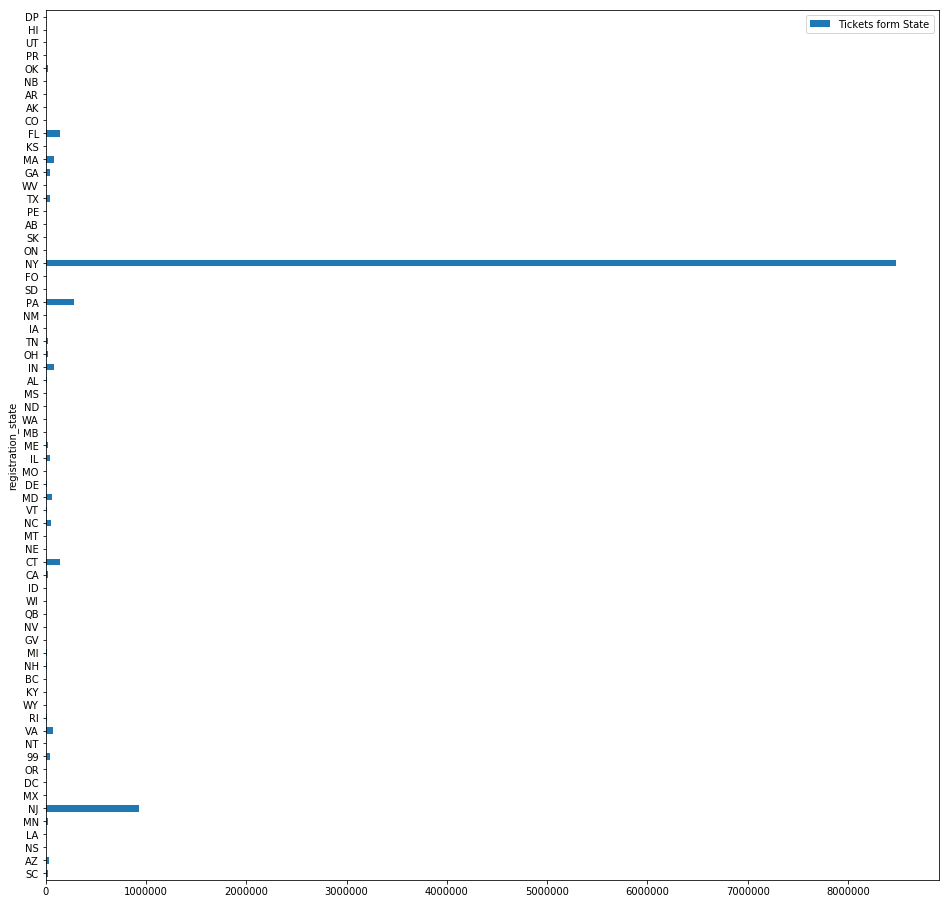

In [19]:
# Visualizing distribution of Tickets

# Visualizing distribution of Tickets w.r.t Registration State
distribution_of_tickets = spark.sql("SELECT `registration_state`, count(*) as `Tickets form State` FROM df_table GROUP BY `registration_state`")
plotdata = distribution_of_tickets.toPandas().set_index('registration_state').plot.barh(figsize=(16, 16))

# Summary of Visualization:
# We have maximum number of Tickets from NY and it is several times more than that of tickets coming from other states
# We have an entry of 99 as state name, which is invalid

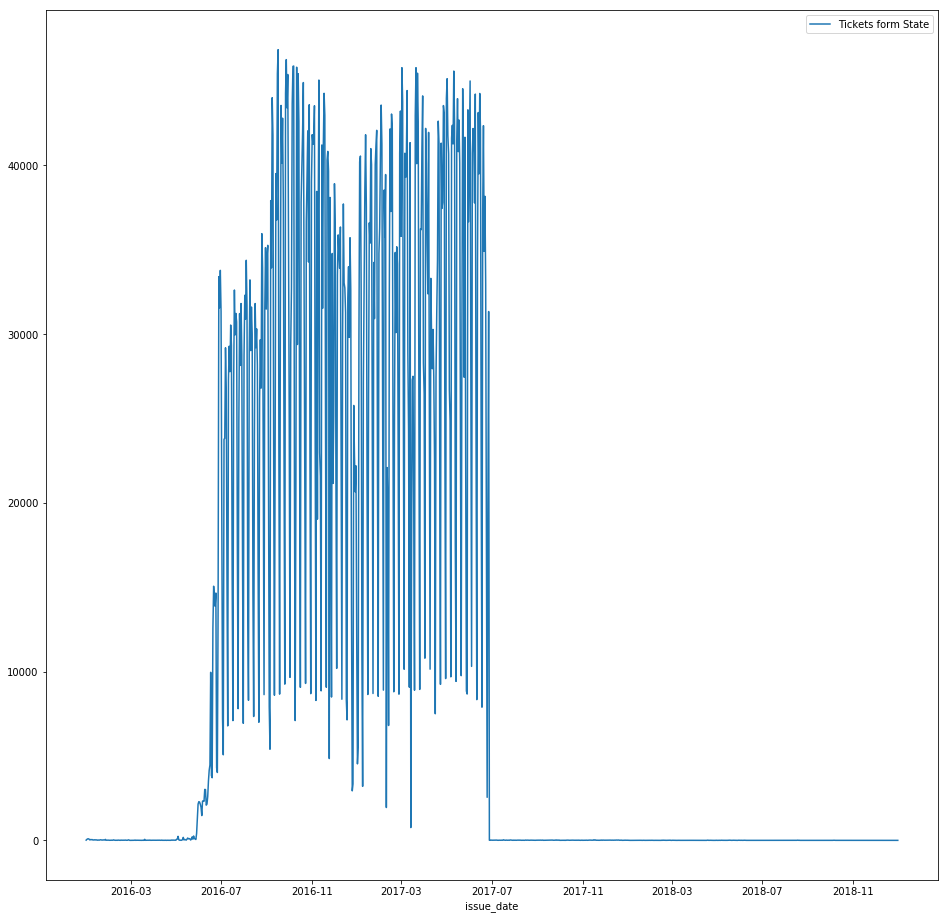

In [20]:
# Visualizing distribution of Tickets

# Visualizing distribution of Tickets w.r.t Issue Date
distribution_of_tickets = spark.sql("SELECT `issue_date`, count(*) as `Tickets form State` FROM df_table  WHERE YEAR(`issue_date`) IN (2016,2017,2018) GROUP BY `issue_date`")
plotdata = distribution_of_tickets.toPandas().set_index('issue_date').plot.line(figsize=(16, 16))

# Summary of Visualization:
# The distribution of tickets across Issue Date is very random.
# It seems like we do not have much data available for the later 6 months
# On some days, we have very high numbers (> 40,000)
# On some days, we have very less numbers (< 10,000)
# On most days, we have no tickets at all (~ 0)

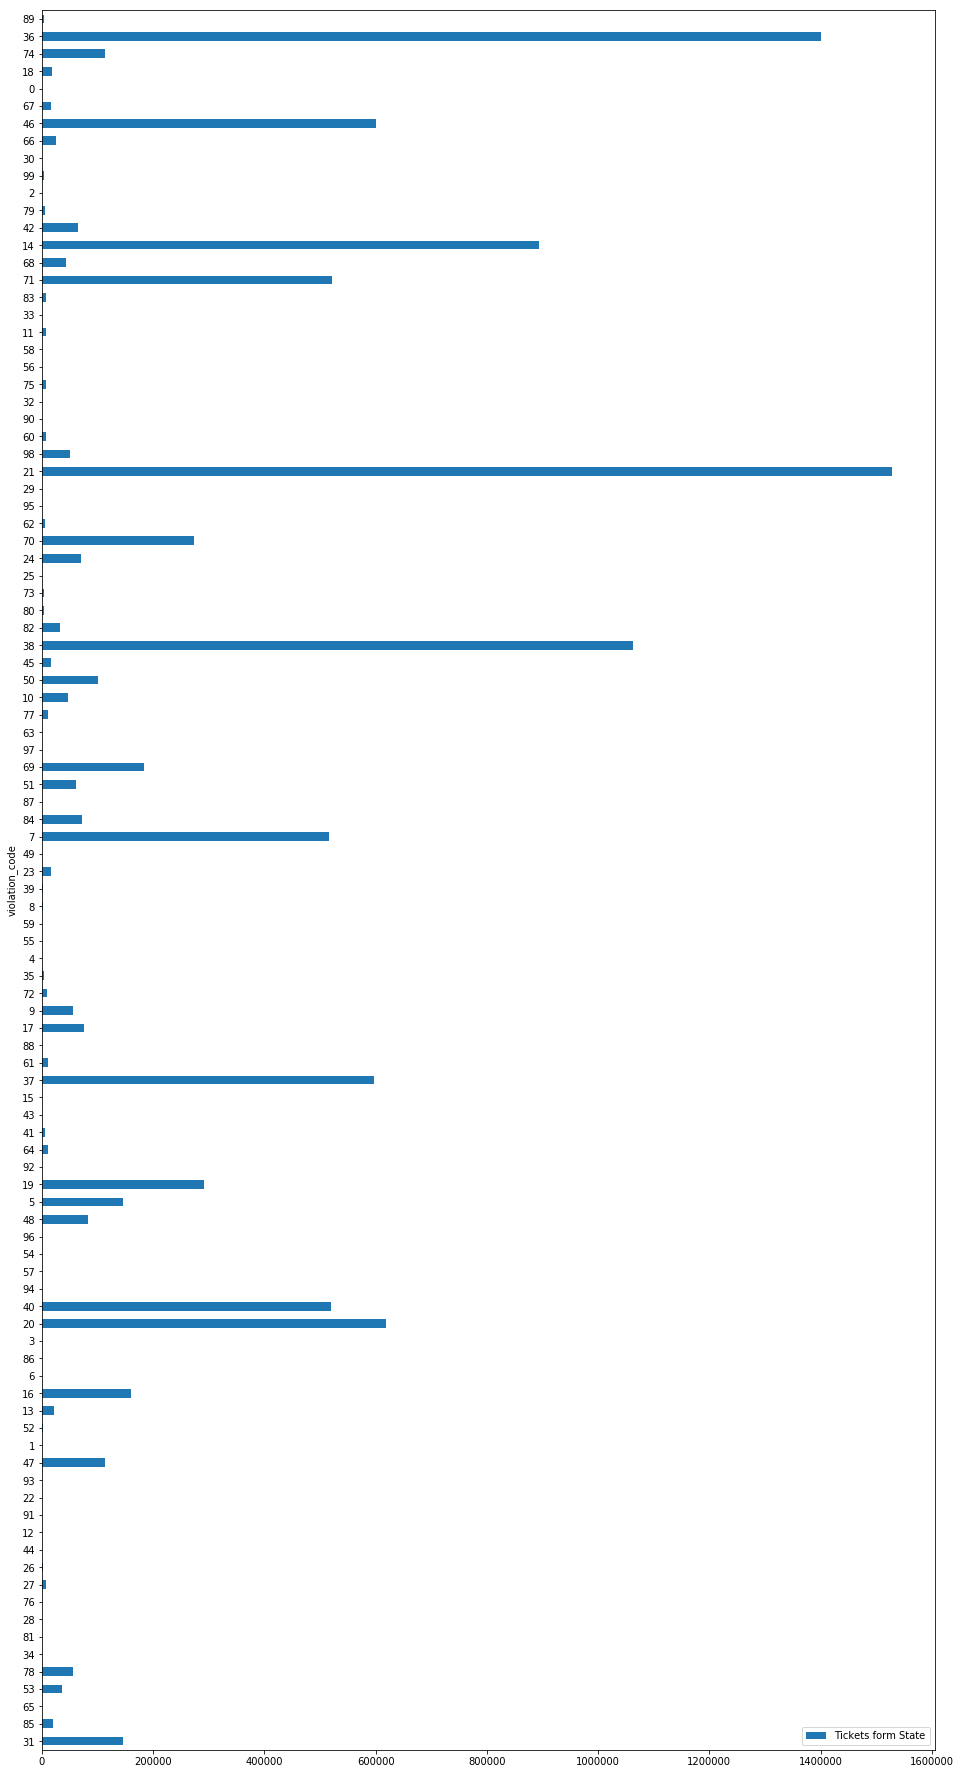

In [21]:
# Visualizing distribution of Tickets

# Visualizing distribution of Tickets w.r.t Violation Code
distribution_of_tickets = spark.sql("SELECT `violation_code`, count(*) as `Tickets form State` FROM df_table GROUP BY `violation_code`")
plotdata = distribution_of_tickets.toPandas().set_index('violation_code').plot.barh(figsize=(16, 32))

# Summary of Visualization:
# The distribution of tickets across Violation Code is random. 
# We have max. number of tickets with violation code 21, followed by 36 and 38

---

### Cleaning Dataset for Analysis

In [22]:
# Counting the initial number of rows from uncleaned data

df.count()

10803028

In [23]:
# Further Cleaning Dataset based on observations from EDA and provided data.
# We are using PySpark Dataframes for the data cleaning purpose for simplicity.

# Handling Duplicate Values
df = df.dropDuplicates()

# Handling Null Values
# If null values are less than 30%, then dropping them
df_drop = df.na.drop()
# print((df_drop.count()/df.count())*100)
if (df_drop.count()/df.count())*100<30:
    df = df_drop

# Replacing the State '99' with the State having the maximum entries, i.e. 'NY'
df = df.withColumn('registration_state', regexp_replace('registration_state', '99', 'NY'))

# Re-registering the cleaned Dataset as SQL view for further Analysis
df.createOrReplaceTempView("df_table")

In [24]:
# Counting the final number of rows from cleaned data

df.count()

10803028

**NOTE: We have not deleted any row, and we have cleaned the Data for NA values but there are no directly identifiable NA values. <br/>
Python would fail to recognize the strings having values as "NULL" or "NA". <br/>
This would be considered as non-NA value which is being considered fine for this analysis.**

If needed, we can clean those values in following ways:
* Deleting the rows that contains string "NULL", "NA" or similar in any of the columns (using filter/where)
* Imputing the rows that contains string "NULL", "NA" or similar in any of the columns (using regexp_replace)

---

### Solving Analysis Questions (Examine the data)

In [25]:
# Examine the data
# Q1. Find the total number of tickets for the year.

# Solution:
# 2. We need to retrieve the count of rows

result = spark.sql("SELECT count(*) as `number of tickets for the year` FROM df_table")
result.show()

+------------------------------+
|number of tickets for the year|
+------------------------------+
|                      10803028|
+------------------------------+



In [26]:
# Examine the data
# Q2. Find out the number of unique states from where the cars that got parking tickets came.

# Solution:
# 1. We need to count the DISTINCT registration_state from the table

result = spark.sql("SELECT  count(DISTINCT `registration_state`) FROM df_table")
result.show()

+----------------------------------+
|count(DISTINCT registration_state)|
+----------------------------------+
|                                66|
+----------------------------------+



---

### Solving Analysis Questions (Aggregation tasks)

### Question 1:

In [27]:
# Aggregation tasks
# Q1. How often does each violation code occur? Display the frequency of the top five violation codes.

# Solution:
# 1. We will count the number of tickets per violation code using GROUP BY
# 2. We will sort the result on basis of count of number of tickers per violation code using ORDER BY DESC
# 3. We will select the top 5 rows only by using LIMIT

result = spark.sql(
    "SELECT `violation_code`, count(*) as `number of tickets for the violation code` \
    FROM df_table \
    GROUP BY `violation_code` \
    ORDER BY `number of tickets for the violation code` DESC \
    LIMIT 5")
result.show()

+--------------+----------------------------------------+
|violation_code|number of tickets for the violation code|
+--------------+----------------------------------------+
|            21|                                 1528588|
|            36|                                 1400614|
|            38|                                 1062304|
|            14|                                  893498|
|            20|                                  618593|
+--------------+----------------------------------------+



---

### Question 2:

In [28]:
# Aggregation tasks
# Q2. How often does each 'vehicle body type' get a parking ticket? How about the 'vehicle make'? (Hint: Find the top 5 for both.)

# Solution:
# 1.1 We will count the number of tickets per 'vehicle body type' using GROUP BY
# 1.2 We will sort the result on basis of count of number of tickers per vehicle body type using ORDER BY DESC
# 1.3 We will select the top 5 rows only by using LIMIT

# 2.1 We will count the number of tickets per 'vehicle make' using GROUP BY
# 2.2 We will sort the result on basis of count of number of tickers per vehicle make using ORDER BY DESC
# 2.3 We will select the top 5 rows only by using LIMIT

# 1:
result = spark.sql(
    "SELECT `vehicle_body_type`, count(*) as `number of tickets for the vehicle body type` \
    FROM df_table \
    GROUP BY `vehicle_body_type` \
    ORDER BY `number of tickets for the vehicle body type` DESC \
    LIMIT 5")
result.show()

# 2:
result = spark.sql(
    "SELECT `vehicle_make`, count(*) as `number of tickets for the vehicle make` \
    FROM df_table \
    GROUP BY `vehicle_make` \
    ORDER BY `number of tickets for the vehicle make` DESC \
    LIMIT 5")
result.show()

+-----------------+-------------------------------------------+
|vehicle_body_type|number of tickets for the vehicle body type|
+-----------------+-------------------------------------------+
|             SUBN|                                    3719802|
|             4DSD|                                    3082020|
|              VAN|                                    1411970|
|             DELV|                                     687330|
|              SDN|                                     438191|
+-----------------+-------------------------------------------+

+------------+--------------------------------------+
|vehicle_make|number of tickets for the vehicle make|
+------------+--------------------------------------+
|        FORD|                               1280958|
|       TOYOT|                               1211451|
|       HONDA|                               1079238|
|       NISSA|                                918590|
|       CHEVR|                               

---

### Question 3:

In [29]:
# Aggregation tasks
# Q3. A precinct is a police station that has a certain zone of the city under its command. 
# Find the (5 highest) frequencies of tickets for each of the following:
# 'Violation Precinct' (This is the precinct of the zone where the violation occurred). 
#     Using this, can you draw any insights for parking violations in any specific areas of the city?
# 'Issuer Precinct' (This is the precinct that issued the ticket.)
# Here, you would have noticed that the dataframe has the'Violating Precinct' or 'Issuing Precinct' as '0'. These are erroneous entries. Hence, you need to provide the records for five correct precincts. (Hint: Print the top six entries after sorting.)

# Solution:
# 1.1 We will count the number of tickets per 'Violation Precinct' using GROUP BY
# 1.2 We will sort the result on basis of count of number of tickers per Violation Precinct using ORDER BY DESC
# 1.3 We will select the top 6 rows only by using LIMIT, not 5 since we ignore the erroneous entries ('0')

# 2.1 We will count the number of tickets per 'Issuer Precinct' using GROUP BY
# 2.2 We will sort the result on basis of count of number of tickers per Issuer Precinct using ORDER BY DESC
# 2.3 We will select the top 6 rows only by using LIMIT, not 5 since we ignore the erroneous entries ('0')

# 1:
result = spark.sql(
    "SELECT `violation_precinct`, count(*) as `number of tickets for the violation precinct` \
    FROM df_table \
    GROUP BY `violation_precinct` \
    ORDER BY `number of tickets for the violation precinct` DESC \
    LIMIT 6")
result.show()

# 2:
result = spark.sql(
    "SELECT `issuer_precinct`, count(*) as `number of tickets for the issuer precinct` \
    FROM df_table \
    GROUP BY `issuer_precinct` \
    ORDER BY `number of tickets for the issuer precinct` DESC \
    LIMIT 6")
result.show()

+------------------+--------------------------------------------+
|violation_precinct|number of tickets for the violation precinct|
+------------------+--------------------------------------------+
|                 0|                                     2072400|
|                19|                                      535671|
|                14|                                      352450|
|                 1|                                      331810|
|                18|                                      306920|
|               114|                                      296514|
+------------------+--------------------------------------------+

+---------------+-----------------------------------------+
|issuer_precinct|number of tickets for the issuer precinct|
+---------------+-----------------------------------------+
|              0|                                  2388479|
|             19|                                   521513|
|             14|                      

**Important Observations:**


* We observe that precinct 19, 14, 1, 18 and 114 have been common precinct in both the queries


* We have very high number of violations in the precinct 19 (almost double of 114)

---

### Question 4:

In [30]:
# Aggregation tasks
# Q4. Find the violation code frequencies for three precincts that have issued the most number of tickets. 
# Do these precinct zones have an exceptionally high frequency of certain violation codes? 
# Are these codes common across precincts? 
# (Hint: In the SQL view, use the 'where' attribute to filter among three precincts.)

# Solution:
# 1. We will count the number of tickets per 'Violation Code' for given `issuer precinct` using GROUP BY 
# 2. We will sort the result on basis of count of number of tickers for the issuer precinct per Violation Code using ORDER BY DESC
# 3. We will select the top 5 rows by using LIMIT to observe the most

# For precinct 19
result = spark.sql(
    "SELECT `violation_code`, count(*) as `number of tickets for the issuer precinct = 19 for violation code` \
    FROM df_table \
    WHERE `issuer_precinct`=19 \
    GROUP BY `violation_code` \
    ORDER BY `number of tickets for the issuer precinct = 19 for violation code` DESC \
    LIMIT 10")
result.show()

# For precinct 14
result = spark.sql(
    "SELECT `violation_code`, count(*) as `number of tickets for the issuer precinct = 14 for violation code` \
    FROM df_table \
    WHERE `issuer_precinct`=14 \
    GROUP BY `violation_code` \
    ORDER BY `number of tickets for the issuer precinct = 14 for violation code` DESC \
    LIMIT 10")
result.show()

# For precinct 1
result = spark.sql(
    "SELECT `violation_code`, count(*) as `number of tickets for the issuer precinct = 1 for violation code` \
    FROM df_table \
    WHERE `issuer_precinct`=1 \
    GROUP BY `violation_code` \
    ORDER BY `number of tickets for the issuer precinct = 1 for violation code` DESC \
    LIMIT 10")
result.show()

+--------------+-----------------------------------------------------------------+
|violation_code|number of tickets for the issuer precinct = 19 for violation code|
+--------------+-----------------------------------------------------------------+
|            46|                                                            86390|
|            37|                                                            72437|
|            38|                                                            72344|
|            14|                                                            57563|
|            21|                                                            54700|
|            16|                                                            31353|
|            20|                                                            27352|
|            40|                                                            21513|
|            71|                                                            15107|
|   

**Important Observations:**


* We do have Violation codes with higher overall frequency like Violation Code 14, 46, 38 etc.


* For issuer precinct = 19, 
    * Most common violation code is 46 (double parking)
    * Other frequent violation codes are 37 and 38 (Parking Meter)
    
    
* For issuer precinct = 14, 
    * Most common violation code is 14 (General No Standing)
    * Next frequent violation code is 69 (Failing to show a parking meter receipt, commercial meter zone)
    * Next frequent violation code is 31 (Standing of a non-commercial vehicle in a commercial metered zone)
    
    
* For issuer precinct = 1, 
    * Most common violation code is 14 (General No Standing)
    * Next frequent violation code is 16 (Truck Loading/Unloading)
    * Next frequent violation code is 20 (General No Parking)
    
    
* Violation Code 14 (General No Standing) is common across all the three precincts


* Violation Code 46 (double parking) is also common in two of three precincts


* Violation Code 38 (Failing to show a receipt or tag in the windshield) is also common in two of three precincts

---

### Question 5:

In [31]:
# Aggregation tasks
# Q5. Find out the properties of parking violations across different times of the day:
# Find a way to deal with missing values, if any.
# (Hint: Check for the null values using 'isNull' under the SQL. Also, to remove the null values, check the 'dropna' command in the API documentation.)

# The Violation Time field is specified in a strange format. Find a way to make this a time attribute that you can use to divide into groups.

# Divide 24 hours into six equal discrete bins of time. Choose the intervals as you see fit. For each of these groups, find the three most commonly occurring violations.
# (Hint: Use the CASE-WHEN in SQL view to segregate into bins. To find the most commonly occurring violations, you can use an approach similar to the one mentioned in the hint for question 4.)

# Now, try another direction. For the three most commonly occurring violation codes, find the most common time of the day (in terms of the bins from the previous part).


# Solution:
# 1. We will check for the null values using 'isNull' under the SQL. 
# (Since we have already used df.na.drop() command in our Data Cleaning steps, it would not have any impact now)
# 2. We will use string manipulation to add a new column with Violation Time in suitable format
# 3. We will divide the time in 6 equal bins, thus 4 hours each (0:00-3:59, 4:00-7:59, 8:00-11:59, 12:00-15:59, 16:00-19:59, 20:00-23:59)
# 4. Programmatically we will implement it in SQL using appropriate CASE-WHEN statements
# 5. We will count the number of tickets per 'Violation Code' for given time of day (bin using CASE-WHEN) and then using GROUP BY for 'Violation Code'
# 6. Now in another direction, find the most common time of the day for three most commonly occurring violation codes

# Q5 Part 1:
count_of_na = df.where(
    col("summons_number").isNull() | \
    col("plate_id").isNull() | \
    col("registration_state").isNull() | \
    col("issue_date").isNull() | \
    col("violation_code").isNull() | \
    col("vehicle_body_type").isNull() | \
    col("vehicle_make").isNull() | \
    col("violation_precinct").isNull() | \
    col("issuer_precinct").isNull() | \
    col("violation_time").isNull()
).count()

print(f'There are {count_of_na} null values in the Dataframe')

There are 0 null values in the Dataframe


In [32]:
# Q5 Part 2:
# Identifying all non standard rows in which the HHMM(A/P) standard is not being followed and getting count.
df.select("violation_time", col("violation_time").rlike("^[01][0-9]{3}[AP]$").alias("criteria")).where(col("criteria")=="false").show()
df.select("violation_time", col("violation_time").rlike("^[01][0-9]{3}[AP]$").alias("criteria")).where(col("criteria")=="false").count()

+--------------+--------+
|violation_time|criteria|
+--------------+--------+
|         8732P|   false|
|         073+A|   false|
|           nan|   false|
|         5200P|   false|
|           nan|   false|
|         093+A|   false|
|           nan|   false|
|           nan|   false|
|          0245|   false|
|         5959P|   false|
|         .933A|   false|
|         094/P|   false|
|         10.4A|   false|
|           nan|   false|
|           nan|   false|
|         5810P|   false|
|           nan|   false|
|         5750P|   false|
|         7824P|   false|
|         01.5P|   false|
+--------------+--------+
only showing top 20 rows



242

In [33]:
# Q5 Part 2:
# Since the count of such values is very less, we can either drop or impute them.
# We will go ahead with imputation since other columns of these rows may convey significant information.
new_df = df.withColumn('violation_time', regexp_replace('violation_time', '^.*[^0-9AP].*$', '0000A'))
new_df = new_df.withColumn('violation_time', regexp_replace('violation_time', '^.*[^AP]$', '0000A'))
new_df = new_df.withColumn('violation_time', regexp_replace('violation_time', '^[^01].*$', '0000A'))
new_df = new_df.withColumn('violation_time', regexp_replace('violation_time', '^[0-9AP]{1,4}$', '0000A'))

# Identifying all non standard rows in which the HHMM(A/P) standard is not being followed and getting count.
new_df.select("violation_time", col("violation_time").rlike("^[01][0-9]{3}[AP]$").alias("criteria")).where(col("criteria")=="false").show()
print("Initially 0000A count: ",df.select("violation_time").where(col("violation_time")=="0000A").count())
print("Finally 0000A count: ", new_df.select("violation_time").where(col("violation_time")=="0000A").count())

+--------------+--------+
|violation_time|criteria|
+--------------+--------+
+--------------+--------+

Initially 0000A count:  1182
Finally 0000A count:  1424


In [34]:
# Q5 Part 2:
# Using UDF to perform the necessary string manipulation to convert violation_time to 24 hour time format

# Convert to 24 Hour Format for easy binning
# Also handling many kinds of faulty entries like 13:00 AM or 13:00 PM // since given time must be in 12 hour format
maketime_udf_str_1 = udf(lambda x: x[0:2]+':'+x[2:4]+':00' if x[-1]=="A" or int(x[0:2]) in range(13,25) else str(int(x[0:2])+12)+':'+x[2:4]+':00', StringType())
# Make hour 24 as 00 for later conversion
maketime_udf_str_2 = udf(lambda x: '00'+x[2:] if x[0:2]=="24" else x, StringType())
new_df = new_df.withColumn('violation_time_new', maketime_udf_str_1('violation_time'))
new_df = new_df.withColumn('violation_time_new', maketime_udf_str_2('violation_time_new'))
new_df = new_df.withColumn('violation_time_new_formatted', date_format('violation_time_new', 'H:m:s'))

new_df.printSchema()

root
 |-- summons_number: long (nullable = true)
 |-- plate_id: string (nullable = true)
 |-- registration_state: string (nullable = true)
 |-- issue_date: date (nullable = true)
 |-- violation_code: integer (nullable = true)
 |-- vehicle_body_type: string (nullable = true)
 |-- vehicle_make: string (nullable = true)
 |-- violation_precinct: integer (nullable = true)
 |-- issuer_precinct: integer (nullable = true)
 |-- violation_time: string (nullable = true)
 |-- violation_time_new: string (nullable = true)
 |-- violation_time_new_formatted: string (nullable = true)



In [35]:
# Re-registering the cleaned Dataset as SQL view for further Analysis
new_df.createOrReplaceTempView("df_table_new")

result = spark.sql('SELECT `violation_time`, `violation_time_new`, `violation_time_new_formatted` FROM df_table_new')
result.show(5)

+--------------+------------------+----------------------------+
|violation_time|violation_time_new|violation_time_new_formatted|
+--------------+------------------+----------------------------+
|         1243P|          00:43:00|                      0:43:0|
|         0820P|          20:20:00|                     20:20:0|
|         1148A|          11:48:00|                     11:48:0|
|         0921A|          09:21:00|                      9:21:0|
|         1031A|          10:31:00|                     10:31:0|
+--------------+------------------+----------------------------+
only showing top 5 rows



In [36]:
# Q5 Part 3 & 4:
result = spark.sql(
    'SELECT `violation_code`, count(*) as `number of tickets for the time bin for violation code`, \
    CASE \
    WHEN HOUR(`violation_time_new_formatted`) IN ("0","1","2","3") THEN "00:00 - 03:59" \
    WHEN HOUR(`violation_time_new_formatted`) IN ("4","5","6","7") THEN "04:00 - 07:59" \
    WHEN HOUR(`violation_time_new_formatted`) IN ("8","9","10","11") THEN "08:00 - 11:59" \
    WHEN HOUR(`violation_time_new_formatted`) IN ("12","13","14","15") THEN "12:00 - 15:59" \
    WHEN HOUR(`violation_time_new_formatted`) IN ("16","17","18","19") THEN "16:00 - 19:59" \
    WHEN HOUR(`violation_time_new_formatted`) IN ("20","21","22","23") THEN "20:00 - 23:59" \
    END AS `violation_time_bin` \
    FROM df_table_new \
    GROUP BY `violation_time_bin`,`violation_code`')
result.count()

# Registering the result Dataset as a separate SQL view for further Analysis since there are many rows
result.createOrReplaceTempView("temp_view")

In [37]:
# Q5 Part 5:
print('violation_time_bin="00:00 - 03:59"')
spark.sql(
    'SELECT `violation_code`,  `number of tickets for the time bin for violation code`\
    FROM temp_view \
    WHERE violation_time_bin="00:00 - 03:59" \
    ORDER BY `number of tickets for the time bin for violation code` DESC \
    LIMIT 3').show()

print('violation_time_bin="04:00 - 07:59"')
spark.sql(
    'SELECT `violation_code`,  `number of tickets for the time bin for violation code`\
    FROM temp_view \
    WHERE violation_time_bin="04:00 - 07:59" \
    ORDER BY `number of tickets for the time bin for violation code` DESC \
    LIMIT 3').show()

print('violation_time_bin="08:00 - 11:59"')
spark.sql(
    'SELECT `violation_code`,  `number of tickets for the time bin for violation code`\
    FROM temp_view \
    WHERE violation_time_bin="08:00 - 11:59" \
    ORDER BY `number of tickets for the time bin for violation code` DESC \
    LIMIT 3').show()

print('violation_time_bin="12:00 - 15:59"')
spark.sql(
    'SELECT `violation_code`,  `number of tickets for the time bin for violation code`\
    FROM temp_view \
    WHERE violation_time_bin="12:00 - 15:59" \
    ORDER BY `number of tickets for the time bin for violation code` DESC \
    LIMIT 3').show()

print('violation_time_bin="16:00 - 19:59"')
spark.sql(
    'SELECT `violation_code`,  `number of tickets for the time bin for violation code`\
    FROM temp_view \
    WHERE violation_time_bin="16:00 - 19:59" \
    ORDER BY `number of tickets for the time bin for violation code` DESC \
    LIMIT 3').show()

print('violation_time_bin="20:00 - 23:59"')
spark.sql(
    'SELECT `violation_code`,  `number of tickets for the time bin for violation code`\
    FROM temp_view \
    WHERE violation_time_bin="20:00 - 23:59" \
    ORDER BY `number of tickets for the time bin for violation code` DESC \
    LIMIT 3').show()

violation_time_bin="00:00 - 03:59"
+--------------+-----------------------------------------------------+
|violation_code|number of tickets for the time bin for violation code|
+--------------+-----------------------------------------------------+
|            21|                                               216890|
|            36|                                               211434|
|            38|                                               106871|
+--------------+-----------------------------------------------------+

violation_time_bin="04:00 - 07:59"
+--------------+-----------------------------------------------------+
|violation_code|number of tickets for the time bin for violation code|
+--------------+-----------------------------------------------------+
|            14|                                               141275|
|            21|                                               119466|
|            40|                                               112186|
+-----

In [38]:
# Q5 Part 6:
print('violation_code=38')
spark.sql(
    'SELECT `violation_time_bin`,  `number of tickets for the time bin for violation code`\
    FROM temp_view \
    WHERE violation_code=38 \
    ORDER BY `number of tickets for the time bin for violation code` DESC \
    LIMIT 1').show()

print('violation_code=21')
spark.sql(
    'SELECT `violation_time_bin`,  `number of tickets for the time bin for violation code`\
    FROM temp_view \
    WHERE violation_code=21 \
    ORDER BY `number of tickets for the time bin for violation code` DESC \
    LIMIT 1').show()

print('violation_code=36')
spark.sql(
    'SELECT `violation_time_bin`,  `number of tickets for the time bin for violation code`\
    FROM temp_view \
    WHERE violation_code=36 \
    ORDER BY `number of tickets for the time bin for violation code` DESC \
    LIMIT 1').show()

violation_code=38
+------------------+-----------------------------------------------------+
|violation_time_bin|number of tickets for the time bin for violation code|
+------------------+-----------------------------------------------------+
|     12:00 - 15:59|                                               356354|
+------------------+-----------------------------------------------------+

violation_code=21
+------------------+-----------------------------------------------------+
|violation_time_bin|number of tickets for the time bin for violation code|
+------------------+-----------------------------------------------------+
|     08:00 - 11:59|                                              1182676|
+------------------+-----------------------------------------------------+

violation_code=36
+------------------+-----------------------------------------------------+
|violation_time_bin|number of tickets for the time bin for violation code|
+------------------+------------------------

**Important Points and Observations:**

**We have cleaned the data for violation_time column with clean data in violation_time_new_formatted column**, however, other columns may still contain error values (including 'null', etc.)
Python would fail to recognize the strings having values as "NULL" or "NA". This would be considered as non-NA value which is being considered fine for this analysis.

If needed, we can clean those values in following ways:
* Deleting the rows that contains string "NULL", "NA" or similar in any of the columns (using filter/where)
* Imputing the rows that contains string "NULL", "NA" or similar in any of the columns (using regexp_replace)

---
For violation_time_bin="00:00 - 03:59", common violations were:
* 21 - Street Cleaning: No parking where parking is not allowed by sign, street marking or traffic control device.
* 36 - Exceeding the posted speed limit in or near a designated school zone.
* 38 - Failing to show a receipt or tag in the windshield. Drivers get a 5-minute grace period past the expired time on parking meter receipts.

For violation_time_bin="04:00 - 07:59", common violations were:
* 14 - General No Standing: Standing or parking where standing is not allowed by sign, street marking or; traffic control device.
* 21 - Street Cleaning: No parking where parking is not allowed by sign, street marking or traffic control device.
* 40 - Stopping, standing or parking closer than 15 feet of a fire hydrant. Between sunrise and sunset, a passenger vehicle may stand alongside a fire hydrant as long as a driver remains behind the wheel and is ready to move the vehicle if required to do so.

For violation_time_bin="08:00 - 11:59", common violations were:
* 21 - Street Cleaning: No parking where parking is not allowed by sign, street marking or traffic control device.
* 36 - Exceeding the posted speed limit in or near a designated school zone.
* 38 - Failing to show a receipt or tag in the windshield. Drivers get a 5-minute grace period past the expired time on parking meter receipts.

For violation_time_bin="12:00 - 15:59", common violations were:
* 36 - Exceeding the posted speed limit in or near a designated school zone.
* 38 - Failing to show a receipt or tag in the windshield. Drivers get a 5-minute grace period past the expired time on parking meter receipts.
* 37 - Parking in excess of the allowed time 

For violation_time_bin="16:00 - 19:59", common violations were:
* 38 - Failing to show a receipt or tag in the windshield. Drivers get a 5-minute grace period past the expired time on parking meter receipts.
* 37 - Parking in excess of the allowed time 
* 14 - General No Standing: Standing or parking where standing is not allowed by sign, street marking or; traffic control device.

For violation_time_bin="20:00 - 23:59", common violations were:
* 7  - Vehicles photographed going through a red light at an intersection.
* 38 - Failing to show a receipt or tag in the windshield. Drivers get a 5-minute grace period past the expired time on parking meter receipts.
* 14 - General No Standing: Standing or parking where standing is not allowed by sign, street marking or; traffic control device.

**Based on above observations, our most common 3 codes are 38, 21, 36**

For violation code 38, most common time of the day is "12:00 - 15:59" i.e. Afternoon

For violation code 21, most common time of the day is "08:00 - 11:59" i.e. Night

For violation code 36, most common time of the day is "08:00 - 11:59" i.e. Night

---

### Question 6:

In [39]:
# Aggregation tasks
# Q6. Let’s try and find some seasonality in this data:

# First, divide the year into a certain number of seasons, and find the frequencies of tickets for each season. (Hint: Use Issue Date to segregate into seasons.)

# Then, find the three most common violations for each of these seasons.
# (Hint: You can use an approach similar to the one mentioned in the hint for question 4.)


# Solution:
# 1. Using data available at https://www.nyc.com/visitor_guide/weather_facts.75835/
# Winter: December, January, February
# Spring: March, April, May
# Summer: June, July, August
# Fall: September, October, November

result = spark.sql(
    'SELECT `violation_code`, count(*) as `number of tickets for the season for violation code`, \
    CASE \
    WHEN MONTH(`issue_date`) IN ("12","1","2") THEN "Winter" \
    WHEN MONTH(`issue_date`) IN ("3","4","5") THEN "Spring" \
    WHEN MONTH(`issue_date`) IN ("6","7","8") THEN "Summer" \
    WHEN MONTH(`issue_date`) IN ("9","10","11") THEN "Fall" \
    END AS `season` \
    FROM df_table_new \
    GROUP BY `season`,`violation_code`')
result.count()

# Registering the result Dataset as a separate SQL view for further Analysis since there are many rows
result.createOrReplaceTempView("temp_view")

In [40]:
# Q6 Part 2:

print('season="Winter"')
spark.sql(
    'SELECT `violation_code`,  `number of tickets for the season for violation code`\
    FROM temp_view \
    WHERE season="Winter" \
    ORDER BY `number of tickets for the season for violation code` DESC \
    LIMIT 3').show()

print('season="Spring"')
spark.sql(
    'SELECT `violation_code`,  `number of tickets for the season for violation code`\
    FROM temp_view \
    WHERE season="Spring" \
    ORDER BY `number of tickets for the season for violation code` DESC \
    LIMIT 3').show()

print('season="Summer"')
spark.sql(
    'SELECT `violation_code`,  `number of tickets for the season for violation code`\
    FROM temp_view \
    WHERE season="Summer" \
    ORDER BY `number of tickets for the season for violation code` DESC \
    LIMIT 3').show()

print('season="Fall"')
spark.sql(
    'SELECT `violation_code`,  `number of tickets for the season for violation code`\
    FROM temp_view \
    WHERE season="Fall" \
    ORDER BY `number of tickets for the season for violation code` DESC \
    LIMIT 3').show()

season="Winter"
+--------------+---------------------------------------------------+
|violation_code|number of tickets for the season for violation code|
+--------------+---------------------------------------------------+
|            21|                                             362341|
|            36|                                             359338|
|            38|                                             259723|
+--------------+---------------------------------------------------+

season="Spring"
+--------------+---------------------------------------------------+
|violation_code|number of tickets for the season for violation code|
+--------------+---------------------------------------------------+
|            21|                                             402807|
|            36|                                             344834|
|            38|                                             271192|
+--------------+---------------------------------------------------+



**Important Observations:**


* We have divided the year based on the imformation from external reference (https://www.nyc.com/visitor_guide/weather_facts.75835/):
    * Winter: December, January, February
    * Spring: March, April, May
    * Summer: June, July, August
    * Fall: September, October, November


* For season="Winter", the following violation codes were most frequent:
    * 21 - Street Cleaning: No parking where parking is not allowed by sign, street marking or traffic control device.
    * 36 - Exceeding the posted speed limit in or near a designated school zone.
    * 38 - Failing to show a receipt or tag in the windshield. Drivers get a 5-minute grace period past the expired time on parking meter receipts.


* For season="Spring", the following violation codes were most frequent:
    * 21 - Street Cleaning: No parking where parking is not allowed by sign, street marking or traffic control device.
    * 36 - Exceeding the posted speed limit in or near a designated school zone.
    * 38 - Failing to show a receipt or tag in the windshield. Drivers get a 5-minute grace period past the expired time on parking meter receipts.


* For season="Summer", the following violation codes were most frequent:
    * 21 - Street Cleaning: No parking where parking is not allowed by sign, street marking or traffic control device.
    * 38 - Failing to show a receipt or tag in the windshield. Drivers get a 5-minute grace period past the expired time on parking meter receipts.
    * 36 - Exceeding the posted speed limit in or near a designated school zone.


* For season="Fall", the following violation codes were most frequent:
    * 36 - Exceeding the posted speed limit in or near a designated school zone.
    * 21 - Street Cleaning: No parking where parking is not allowed by sign, street marking or traffic control device.
    * 38 - Failing to show a receipt or tag in the windshield. Drivers get a 5-minute grace period past the expired time on parking meter receipts.


* For all the seasons, the top 3 violation codes are same with some change in order over seasons.

---

### Question 7:

In [41]:
# Aggregation tasks
# Q7. The fines collected from all the instances of parking violation constitute a source of revenue for the NYC Police Department. Let’s take an example of estimating this for the three most commonly occurring codes:
# Find the total occurrences of the three most common violation codes.
# Then, visit the website: http://www1.nyc.gov/site/finance/vehicles/services-violation-codes.page
# It lists the fines associated with different violation codes. They’re divided into two categories: one for the highest-density locations in the city and the other for the rest of the city. For the sake of simplicity, take the average of the two.
# Using this information, find the total amount collected for the three violation codes with the maximum tickets. State the code that has the highest total collection.
# What can you intuitively infer from these findings?

# Solution:
# 1. Finding total occurrences of the three most common violation codes using GROUP BY
# 2. Average fine for top 3 occuring violation codes:
#    violation code 21 => (45 + 65)/2 => 55
#    violation code 36 => (50 + 50)/2 => 50
#    violation code 38 => (65 + 35)/2 => 50
# As per the referred website: The table below defines the parking violation codes in New York City and lists the fines. 
# Each fine amount includes a $15 New York State Criminal Justice surcharge.

# 1:
result = spark.sql(
    'SELECT `violation_code`, count(*) as `number of tickets for the violation code` \
    FROM df_table_new \
    GROUP BY `violation_code` \
    ORDER BY `number of tickets for the violation code` DESC \
    LIMIT 3')
result.show()

# 2:
print(f'Revenue generation from violation code 21 (count:1528588 , avg. fine: $55) = ${1528588*55}')
print(f'Revenue generation from violation code 36 (count:1400614 , avg. fine: $50) = ${1400614*50}')
print(f'Revenue generation from violation code 38 (count:1062304 , avg. fine: $50) = ${1062304*50}')

+--------------+----------------------------------------+
|violation_code|number of tickets for the violation code|
+--------------+----------------------------------------+
|            21|                                 1528588|
|            36|                                 1400614|
|            38|                                 1062304|
+--------------+----------------------------------------+

Revenue generation from violation code 21 (count:1528588 , avg. fine: $55) = $84072340
Revenue generation from violation code 36 (count:1400614 , avg. fine: $50) = $70030700
Revenue generation from violation code 38 (count:1062304 , avg. fine: $50) = $53115200


**Important Observations:**


* Revenue generation from violation code 21 (count:1528588 , avg. fine: \$55) = **\$84072340**
    * Violation code 21 means: Street Cleaning: No parking where parking is not allowed by sign, street marking or traffic control device.
    
    
* Revenue generation from violation code 36 (count:1400614 , avg. fine: \$50) = **\$70030700**
    * Violation code 36 mean: Exceeding the posted speed limit in or near a designated school zone.
    
    
* Revenue generation from violation code 38 (count:1062304 , avg. fine: \$50) = **\$53115200**
    * Violation code 38 means: Failing to show a receipt or tag in the windshield. Drivers get a 5-minute grace period past the expired time on parking meter receipts.
    
    
* Violation Code 21 has the highest total collection of \$84072340


* We can intuitively infer the following from these findings:
    * Most violations are due to **parking related issues**.
    * There is certainly **parking related problem in NYC**.
    * Many people are **violating the posted speed limit criteria**.


In [42]:
# Closing the Spark session
spark.stop()